<a href="https://colab.research.google.com/github/visgraf/labipcv/blob/main/notebooks/ImprovedGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving GANs with convolutions and spectral normalization

This notebook was prepared for the course Fundamentals and Trends in Vision and Image Processing of IMPA in 2021. 

The notebook content was based on Goodfellow's [first paper on GANs](https://arxiv.org/abs/1406.2661) and the Diego Alejo's public [implementation](https://github.com/diegoalejogm/gans/blob/master/utils.py)

In [1]:
import matplotlib.pyplot as plt
import os
import pickle
import torch

from IPython import display
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")

Running on cuda


In [4]:
# I'll store my data in Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Make sure to use a valid path for you
DATA_DIR = 'data'
OUTPUT_DIR = 'out-dcgan'
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')
IMG_DIR = os.path.join(OUTPUT_DIR, 'results')

# Deep Convolutional Generative Adversarial Networks

In this section, we are going to modify our networks architectures following the guidelines proposed in DCGAN.

* [Check the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf)

In [4]:
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this size
image_size = 64

## Loading MNIST using Torchvision

Note that we resize the images to a resolution of 64x64

In [5]:
def mnist_data(datapath=DATA_DIR):
    compose = transforms.Compose(
        [transforms.Resize(image_size),
            transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = '{}/dataset'.format(datapath)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [6]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [9]:
def lookat_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(12, 4))
  rows, cols = 2, 8
  for i in range(1, rows*cols + 1):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(label)
      plt.axis("off")
      if istensor:
        img = img.squeeze()
        if len(img.shape) == 2:
          plt.imshow(img, cmap='gray')
        else:
          img = (img * 0.5) + 0.5
          plt.imshow(img.permute(1, 2, 0))
      else:
        plt.imshow(img)
  plt.show()

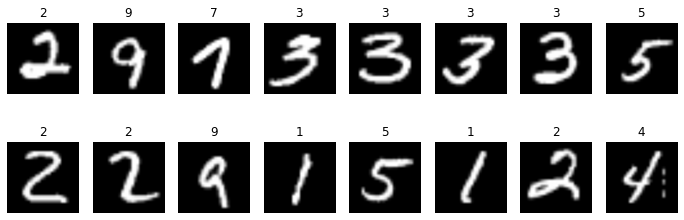

In [10]:
lookat_dataset(data, True)

## Networks architectures

Inserir imagem

In [11]:
class DiscriminatorNet(nn.Module):
    def __init__(self, d, nc):
        super().__init__()
       
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (d) x 32 x 32
            nn.Conv2d(d, d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (d*2) x 16 x 16
            nn.Conv2d(d * 2, d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (d*4) x 8 x 8
            nn.Conv2d(d * 4, d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (d*8) x 4 x 4
            nn.Conv2d(d * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).squeeze()

    
class GeneratorNet(nn.Module):
    def __init__(self, noise_dim, d, nc):
        super().__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( noise_dim, d * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(d * 8),
            nn.ReLU(True),
            # state size. (d*8) x 4 x 4
            nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d * 4),
            nn.ReLU(True),
            # state size. (d*4) x 8 x 8
            nn.ConvTranspose2d( d * 4, d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d * 2),
            nn.ReLU(True),
            # state size. (d*2) x 16 x 16
            nn.ConvTranspose2d( d * 2, d, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d),
            nn.ReLU(True),
            # state size. (d) x 32 x 32
            nn.ConvTranspose2d( d, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, z):
        return self.main(z)


In [12]:
# custom weights initialization called on generator and discriminator
def weights_init(m, mean=0.0, std=0.02):
    classname = m.__class__.__name__
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
# Size of z latent vector (i.e. size of generator input)
nz = 100
generator = GeneratorNet(nz, image_size, 1).to(device)
discriminator = DiscriminatorNet(image_size, 1).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

DiscriminatorNet(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Helper functions for visualization and checkpointing

In [16]:
from utils import noise, real_data_target, fake_data_target, log_images, save_models, save_losses, load_models, load_losses, plot_losses, make_gif

### Generate Samples for Testing

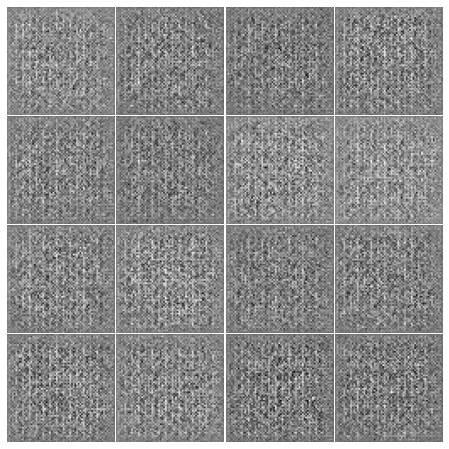

In [15]:
num_test_samples = 16
torch.manual_seed(7777)
imagepath = os.path.join(IMG_DIR, f'{0}.jpg')
test_noise = noise(num_test_samples, nz, device)
log_images(generator(test_noise).cpu().detach().numpy(), 
                imagepath)

## Optimization hyperparameters

We want to optimize:

$$\begin{align*} 
\min_{G} \max_{D} V(D, G) = E_{x∼p_{data}(x)}[logD(x)] + E_{z∼p_z(z)}[log(1 −D(G(z)))]
\end{align*} $$

In PyTorch, we can implement it in terms of Binary Cross Entropy:

$$−[y_nlog(\hat{y}_n) +(1−y_n)log(1−\hat{y}_n)]$$


* [BCELoss PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

When we have **real data**, $y_n=1$, $\hat{y_n}=D(x_n)$ and we stay with:

$$−log(D(x_n)) $$

On the other hand, when we have **fake data**, $y_n=0$, $\hat{y}_n=D(G(z_n))$ and we stay with:

$$−log(1−D(G(z_n)))$$

In [20]:
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 100

## Training

In [22]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0), device))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0), device))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0), device))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Start training

In [28]:
last_epoch = 0
checkpoint_rate = 50

D_losses = []
G_losses = []
# if we are resuming the training
if last_epoch > 0:
  generator, discriminator = load_models(last_epoch, MODELS_DIR)
  G_losses, D_losses = load_losses(last_epoch, MODELS_DIR)

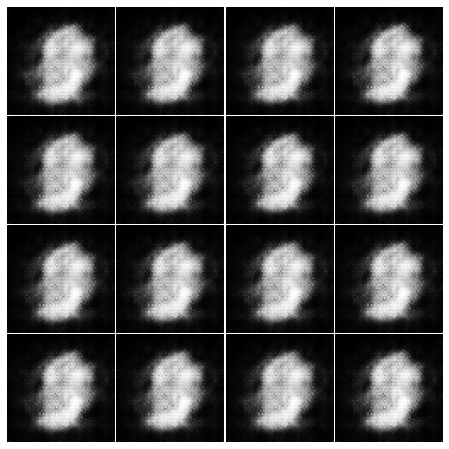

Epoch: 99/100 Losses:
Discriminator: 100.0000; Generator: 0.0000
D(x): 1.0000; D(G(z)): 1.0000


In [29]:
def train_nets(generator, discriminator, g_optimizer, d_optimizer, data_loader, num_epochs, 
            last_epoch=0, D_losses=[], G_losses=[]):
    for epoch in range(last_epoch, num_epochs):
        for n_batch, (real_batch,_) in enumerate(data_loader):
            # 1. Train Discriminator
            real_data = real_batch.to(device)
            # Generate fake data
            fake_data = generator(noise(real_data.size(0), nz, device)).detach()
            # Train D
            d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                    real_data, fake_data)

            # 2. Train Generator
            # Generate fake data
            fake_data = generator(noise(real_batch.size(0), nz, device))
            # Train G
            g_error = train_generator(g_optimizer, fake_data)

        display.clear_output(True)
        # Show generated images
        imagepath = os.path.join(IMG_DIR, f'{epoch+1}.jpg')
        test_images = generator(test_noise).cpu().detach().numpy()
        log_images(test_images, imagepath)
        
        # Display status Logs
        G_losses.append(g_error)
        D_losses.append(d_error)
        print(f"Epoch: {epoch}/{num_epochs} Losses:")
        print(f"Discriminator: {d_error:.4f}; Generator: {g_error:.4f}")
        print(f"D(x): {d_pred_real.mean():.4f}; D(G(z)): {d_pred_fake.mean():.4f}")
        
        if (epoch+1) % checkpoint_rate == 0:
            # Save model checkpoints
            save_models(generator, discriminator, epoch, MODELS_DIR) 
            save_losses(G_losses, D_losses, epoch, MODELS_DIR)
    return G_losses, D_losses

In [ ]:
G_losses, D_losses = train_nets(generator, discriminator, g_optimizer, d_optimizer, data_loader, 50)

# Visualizing the results

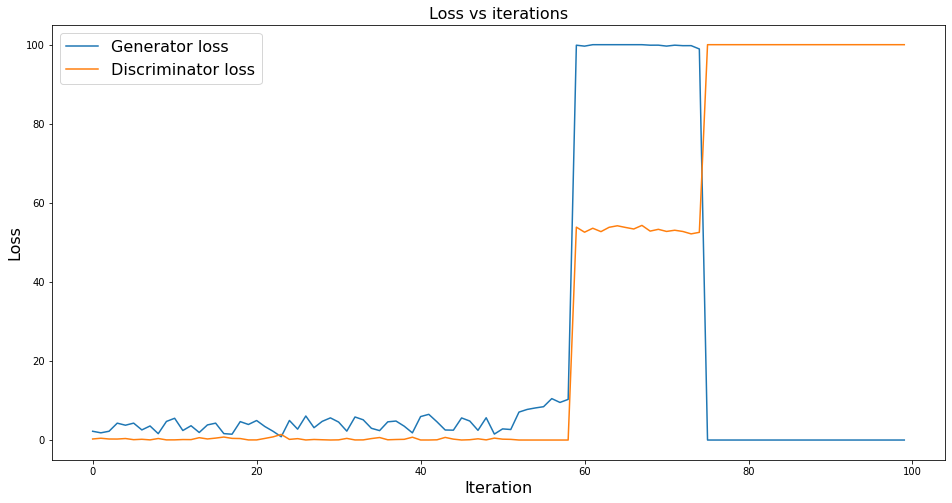

In [31]:
plot_losses({"Generator loss": G_losses, "Discriminator loss": D_losses})

### Let's make a GIF of the training process

In [ ]:
make_gif(os.path.join(OUTPUT_DIR, 'GAN_training.gif'), IMG_DIR)

# Spectral normalization

In [34]:
from torch.nn.utils import spectral_norm

In [35]:
class SpectralConv(nn.Module):
  def __init__(self, *args, **kwargs):
    super().__init__()
    self.conv = spectral_norm(nn.Conv2d(*args, **kwargs))

  def forward(self, x):
    return self.conv(x)

In [39]:
class SpectralDiscriminatorNet(nn.Module):
    def __init__(self, d, nc):
        super().__init__()
       
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            SpectralConv(nc, d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. d x 32 x 32
            SpectralConv(d, d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (d*2) x 16 x 16
            SpectralConv(d * 2, d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (d*4) x 8 x 8
            SpectralConv(d * 4, d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (d*8) x 4 x 4
            SpectralConv(d * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).squeeze()

In [72]:
discriminator = SpectralDiscriminatorNet(image_size, 3).to(device)
generator = GeneratorNet(nz, image_size, 3).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

SpectralDiscriminatorNet(
  (main): Sequential(
    (0): SpectralConv(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): SpectralConv(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): SpectralConv(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): SpectralConv(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=

# Celeb Dataset

In [58]:
# Make sure to use a valid path for you
DATA_DIR = 'data'
OUTPUT_DIR = 'out-spectral'
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')
IMG_DIR = os.path.join(OUTPUT_DIR, 'results')

In [59]:
celeb_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'celeba'),
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = DataLoader(celeb_dataset, batch_size=batch_size,
                                         shuffle=True)

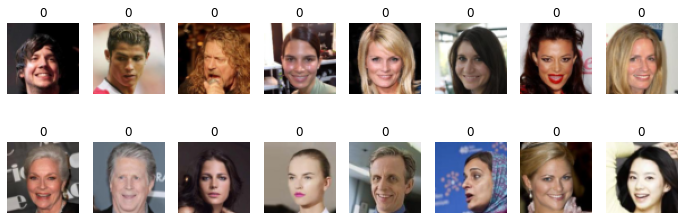

In [71]:
lookat_dataset(celeb_dataset, True)

In [73]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
loss = nn.BCELoss()
# Number of epochs
num_epochs = 50
last_epoch = 0
checkpoint_rate = 10

In [74]:
print(f"Running on {device}")

Running on cuda


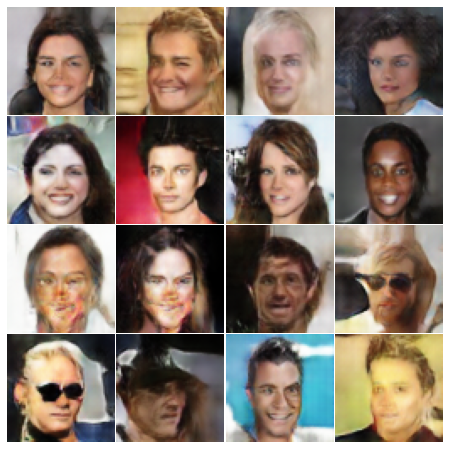

Epoch: 49/50 Losses:
Discriminator: 0.0999; Generator: 4.6314
D(x): 0.9916; D(G(z)): 0.0834


In [75]:
G_losses, D_losses = train_nets(generator, discriminator, g_optimizer, d_optimizer, dataloader, num_epochs)

In [76]:
make_gif(os.path.join(OUTPUT_DIR, 'celebGAN_training.gif'), IMG_DIR)

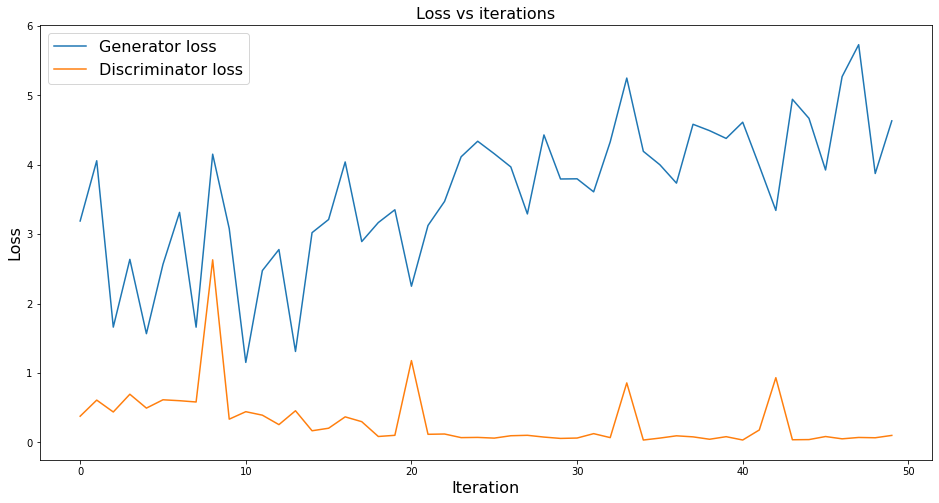

In [80]:
plot_losses({"Generator loss": G_losses, "Discriminator loss": D_losses})